# Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

plt.rcParams["figure.figsize"] = (10,10)

data = json.load(open('xac_tags'))

len(data)

210331

# How the raw data looks like ?

In [26]:
for article in data[:2]:
    print(article)

print(data[0].keys())

{'ID': '110262580', 'Bodytext': 'Der Bayerische Hotel- und Gaststättenverband hat die geplante Lockerung des Tanzverbots an den sogenannten stillen Feiertagen begrüßt. Zurückhaltender reagierten die Kirchen. Man warne vor einer "scheibchenweisen Aushöhlung" der Regelung, sagte ein Sprecher der katholischen Freisinger Bischofskonferenz am Donnerstag. Nach monatelangem Streit hatten sich CSU und FDP darauf geeinigt, dass in der Nacht vor stillen Tagen Partys und andere Tanzveranstaltungen nicht schon um Mitternacht beendet werden müssen, sondern erst um 2 Uhr.\nInnenminister Joachim Herrmann (CSU) betonte: "Der ernste Charakter der stillen Tage bleibt in Bayern weiterhin voll gewahrt." Mit der Anpassung orientiere man sich an die veränderten Lebensgewohnheiten der Menschen. Der Gaststättenverband hätte sich zwar über eine Ausweitung der Öffnungszeiten bis 3 Uhr gefreut, sei aber nun "dankbar" für den Kompromiss, sagte Präsident Ulrich Brandl. Er hofft nun auf eine schnelle gesetzliche Um

# Clean the data a little bit

In [2]:
to_be_removed = ['welt_kompakt', 'die_welt', 'wams' 'print_politik', 'print' 'newsapp']

for article in data:
    categories_for_article = article['Categories']
            
    if len(categories_for_article) == 1 and "." in categories_for_article[0]:
        categories_for_article[0] = ''
        
    if len(categories_for_article) > 1: 
        for current_category in categories_for_article:
            if current_category in to_be_removed:
                categories_for_article.remove(current_category)
                
    for index, category in enumerate(categories_for_article):
        if "_" in category:
            splitted = category.split("_")
            categories_for_article[index] = splitted[1]
            

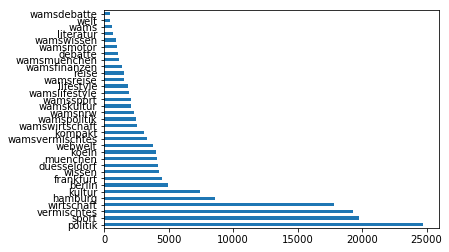

In [3]:
keys = ['Introtext', 'Categories']

df = pd.DataFrame(data, columns=keys)

df['Introtext'].replace('', np.nan, inplace=True)

df.dropna(inplace=True)

def to_s(categories):
    return ''.join(categories)

df['Categories'] = df['Categories'].apply(to_s)

filtered = df.groupby('Categories').filter(lambda x: len(x) >= 250)

pd.value_counts(filtered['Categories']).plot(kind='barh')

# Prepare training and test data

In [15]:
train_size = int(len(filtered) * .8)
train_articles = filtered['Introtext'][:train_size]
train_categories = filtered['Categories'][:train_size]
test_articles = filtered['Introtext'][train_size:]
test_categories = filtered['Categories'][train_size:]
num_labels = pd.value_counts(train_categories).size

print(train_articles.shape)
print(train_articles.ndim)

(127733,)
1


# Tokenize and prepare to data to feed into the neural network

In [16]:
from keras.preprocessing.text import Tokenizer

vocabulary_size = 20000

tokenize = Tokenizer(num_words=vocabulary_size)

tokenize.fit_on_texts(train_articles)

x_train = tokenize.texts_to_matrix(train_categories)

In [17]:
from sklearn import preprocessing
encoder = preprocessing.LabelBinarizer()

encoder.fit(train_categories)

y_train = encoder.transform(train_categories)
y_test = encoder.transform(test_categories)

# Train...

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(512, input_shape=(vocabulary_size,)))
model.add(Activation('relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

batch_size = 64
  
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=3, 
                    verbose=1,
                    validation_split=0.1)

Train on 114959 samples, validate on 12774 samples
Epoch 1/3
114959/114959 [==============================] - 217s 2ms/step - loss: 1.0087 - acc: 0.7484 - val_loss: 0.9242 - val_acc: 0.7496
Epoch 2/3
114959/114959 [==============================] - 222s 2ms/step - loss: 0.9165 - acc: 0.7513 - val_loss: 0.9225 - val_acc: 0.7496
Epoch 3/3
114959/114959 [==============================] - 216s 2ms/step - loss: 0.9157 - acc: 0.7513 - val_loss: 0.9253 - val_acc: 0.7496


# Let's try it out

In [58]:
text_labels = encoder.classes_

for ctr in range(10):    
    prediction = model.predict(np.array([x_train[ctr]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_articles.iloc[ctr][:80], "..")
    print('Real category: ' + test_categories.iloc[ctr])
    print("Predicted category: " + predicted_label)

Humor aus Bayern: "Was weg is, is weg" ..
Real category: vermischtes
Predicted category: vermischtes
Der deutsche Basketballstar Henrik Rödl studierte an der Uni, die Jordan prägte. ..
Real category: wamssport
Predicted category: vermischtes
WHO: Anti-Epidemie-Technik des HPI aus Potsdam ++ Walfangkommission: Ministerin  ..
Real category: wissen
Predicted category: vermischtes
Am Sonntag wählen zwei Schlüsselländer ihrer Region Parlament und Regierung. Tun ..
Real category: politik
Predicted category: hamburg
Prozess: Bäckereikette hat Betriebsrat nach Überwachung seines PCs entlassen ..
Real category: muenchen
Predicted category: sport
Konzerte, Poetry Slams, Tanzkurse und ein Restaurant: Der Frannz Club gehört zu  ..
Real category: berlin
Predicted category: sport
Bericht soll NRW-Verkehrsminister Harry Voigtsberger bei Entscheidung helfen ..
Real category: duesseldorf
Predicted category: vermischtes
Und bald auch wieder mit Seife vom Designer ..
Real category: vermischtes
Predicted 